# Florida Food Insecurity Risk Model
#### By Seema Guruvadoo

# Project Goal:  
Test if access to resources like internet, vehicle, and kitchen is linked to food insecurity in Florida counties.  
Build a prediction model that can guess if a county has a high or low risk of food insecurity.  
* Aid NGOs in allocating appropriate resources to high risk counties  
* Understand how important basic resoursces are and how they might drive risk in food security

### Problem Statement:
"Food insecurity is defined by the United States Department of Agriculture (USDA) as the lack of access to enough
food for an active, healthy life due to limited financial resources." 
 -- FeedingAmerica.org

This project will focus primarily on the 'access' pillar of food security   
*food security pillars: access, availability, utilization, and stability*

These 3 variables are chosen at random. The study aims to evaluated 3 resources and determine if lack of access to these resources might be related to high food insecurity.

### Phase 1: Selecting the data

With over 67 counties in Florida, many residents come from various socioeconomical backgrounds. This project aims to evaluate how resources like access to the internet, a vehicle, kitchen may affect food security. Based off this analysis, a further evaluation with a prediction model will determine if the county is at high/low risk. 
Two datasets have been selected to analyze the food access crisis in Florida.
1) "Map the Meal Gap" Data by Feeding America - delineates data on impacted people/children, racial and ethnic identities, % of people who are food insecure and unlikely to quality for federal assistance, and money required to buy just enough food
2) American Community Survey: delineates data on internet access, vehicle access, and kitchen access



### Relevant data to this analysis:

1) Map the Meal Gap: County, State, Year, Overall Food Insecurity Rate
  
2) American Community Survey: Internet Access (B28002), Vehicle Access (B08201), Kitchen Access (B25051)

3) Observed Year: 2019 - 2020 (Please note the year before COVID)

In [3]:
# Import Library

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# Load Data
vehicle_df = pd.read_csv('C:/Users/Seema/OneDrive/Desktop/Insecurity in Food/ACSDT1Y2019.B08201-Data.csv', encoding='latin1') # ACS vehicle data
kitchen_df = pd.read_csv('C:/Users/Seema/OneDrive/Desktop/Insecurity in Food/ACSDT1Y2019.B25051-Data.csv', encoding='latin1') # ACS kitchen data
internet_df = pd.read_csv('C:/Users/Seema/OneDrive/Desktop/Insecurity in Food/ACSDT1Y2019.B28002-Data.csv', encoding='latin1') # ACS internet data
feedAmerica_df = pd.read_csv('C:/Users/Seema/OneDrive/Desktop/Insecurity in Food/FeedAmerica2019-2022.csv', encoding='latin1') # Feed America

### Phase 2: Clean and Merge Datasets

In [5]:
## CLEANING DATA
# Feed America - Food Insecurity Data

# Select relevant columns
feedAmerica_df_sub = feedAmerica_df[["County, State", "State", "Year", "Overall Food Insecurity Rate"]] 

# Drop NAs
feedAmerica_df_sub = feedAmerica_df_sub.dropna()

# Filter year to 2019
feedAmerica_df_sub = feedAmerica_df_sub[(feedAmerica_df_sub['Year'] == 2019) & (feedAmerica_df_sub['State'] == "FL" )]

# Split feedAmerica data - County, State - by ","
feedAmerica_df_sub[['County', 'State']] = feedAmerica_df_sub['County, State'].str.split(',', expand=True) 
feedAmerica_df_sub = feedAmerica_df_sub.drop('County, State', axis = 1)

# Strip % from Food Insecurity Rate
feedAmerica_df_sub['Food Insecurity Rate'] = feedAmerica_df_sub['Overall Food Insecurity Rate'].str.rstrip('%').astype(float)

feedAmerica_df_sub = feedAmerica_df_sub.iloc[:, [3, 4]] # Reorganize columns for ease of visualization

feedAmerica_df_sub.head(5)

,County,Food Insecurity Rate
1284,Alachua County,13.4
1288,Baker County,12.2
1292,Bay County,15.0
1296,Bradford County,16.4
1300,Brevard County,12.0


In [6]:
## CLEANING DATA
# ACS Data - Vehicle Access

# Select relevant columns
vehicle_df_sub = vehicle_df[["NAME", "B08201_001E", "B08201_002E", "B08201_003E"]] 
                            # NAME - Geographic Area Name
                            # B08201_001E - Population
                            # B08201_002E - No vehicle available 
                            # B08201_003E - Has one vehicle

# Drop NAs
vehicle_df_sub = vehicle_df_sub.dropna()

# Split county data - County, State - by ","
vehicle_df_sub[['County', 'State']] = vehicle_df_sub['NAME'].str.split(',', expand=True) 
vehicle_df_sub = vehicle_df_sub.drop(['NAME', 'State'], axis = 1) # Drop NAME and State column as all data is looking at FL data
vehicle_df_sub = vehicle_df_sub.iloc[2:] # Omit first two rows since it's just informative (not actual data)

# Rename columns
vehicle_df_sub = vehicle_df_sub.rename(columns={'B08201_001E': 'County Population', 'B08201_002E': 'No vehicle available', 'B08201_003E': 'Has one vehicle'})

# Normalized Data
vehicle_df_sub[['County Population', 'Has one vehicle', 'No vehicle available']] = vehicle_df_sub[['County Population', 'Has one vehicle', 'No vehicle available']].astype(int)
vehicle_df_sub['Has one vehicle (%)'] = vehicle_df_sub['Has one vehicle'] / vehicle_df_sub['County Population'] * 100
vehicle_df_sub['No vehicle available (%)'] = vehicle_df_sub['No vehicle available'] / vehicle_df_sub['County Population'] * 100

vehicle_df_sub = vehicle_df_sub.iloc[:, [3, 4, 5]] # Reorganize columns for ease of visualization

# Merge Data
df_all = pd.merge(feedAmerica_df_sub, vehicle_df_sub, on='County', how='left')

vehicle_df_sub.head(5)

,County,Has one vehicle (%),No vehicle available (%)
2,Alachua County,40.588601,7.753533
3,Bay County,33.417154,3.826866
4,Brevard County,38.955326,4.207040
5,Broward County,39.174482,7.732695
6,Charlotte County,41.239604,6.339030


*Please note that the 'Vehicle' dataset includes columns for ownership of more than one vehicle. For this study, I chose to focus specifically on the clear distinction between having a car and not having a car.*

In [7]:
## CLEANING DATA
# ACS Data - Kitchen

# Select relevant columns
kitchen_df_sub = kitchen_df[["NAME", "B25051_001E", "B25051_003E", "B25051_002E"]] 
                            # NAME - Geographic Area Name
                            # B25051_001E	- population
                            # B25051_003E - Lacking kitchen available
                            # B25051_002E	- Complete kitchen facility

# Drop NAs
kitchen_df_sub = kitchen_df_sub.dropna()

# Split county data - County, State - by ","
kitchen_df_sub[['County', 'State']] = kitchen_df_sub['NAME'].str.split(',', expand=True) 
kitchen_df_sub = kitchen_df_sub.drop(['NAME', 'State'], axis = 1) # Drop NAME and State column as all data is looking at FL data
kitchen_df_sub = kitchen_df_sub.iloc[2:] # Omit first two rows since it's just informative (not actual data)

# Rename columns
kitchen_df_sub = kitchen_df_sub.rename(columns={'B25051_001E': 'County Population', 'B25051_003E': 'Lacking kitchen available', 'B25051_002E': 'Complete kitchen facility'})

# Normalized Data
kitchen_df_sub[['County Population', 'Complete kitchen facility', 'Lacking kitchen available']] = kitchen_df_sub[['County Population', 'Complete kitchen facility', 'Lacking kitchen available']].astype(int)
kitchen_df_sub['Complete kitchen facility (%)'] = kitchen_df_sub['Complete kitchen facility'] / kitchen_df_sub['County Population'] * 100
kitchen_df_sub['Lacking kitchen available (%)'] = kitchen_df_sub['Lacking kitchen available'] / kitchen_df_sub['County Population'] * 100

kitchen_df_sub = kitchen_df_sub.iloc[:, [3, 4, 5]] # Reorganize columns for ease of visualization

# Merge Data
df_all = pd.merge(df_all, kitchen_df_sub, on='County', how='left')

kitchen_df_sub.head(5)

,County,Complete kitchen facility (%),Lacking kitchen available (%)
2,Alachua County,97.950527,2.049473
3,Bay County,94.899011,5.100989
4,Brevard County,98.814129,1.185871
5,Broward County,99.113896,0.886104
6,Charlotte County,99.226130,0.773870


In [8]:
## CLEANING DATA
# ACS Data - Kitchen

# Select relevant columns
internet_df_sub = internet_df[["NAME", "B28002_001E", "B28002_013E", "B28002_002E"]]
                            # NAME - Geographic Area Name
                            # B28002_001E - population
                            # B28002_013E - No internet subscription
                            # B28002_002E - with internet subscription
# Drop NAs
internet_df_sub = internet_df_sub.dropna()

# Split county data - County, State - by ","
internet_df_sub[['County', 'State']] = internet_df_sub['NAME'].str.split(',', expand=True) 
internet_df_sub = internet_df_sub.drop(['NAME', 'State'], axis = 1) # Drop NAME and State column as all data is looking at FL data
internet_df_sub = internet_df_sub.iloc[2:] # Omit first two rows since it's just informative (not actual data)

# Rename columns
internet_df_sub = internet_df_sub.rename(columns={'B28002_001E': 'County Population', 'B28002_013E': 'No internet subscription', 'B28002_002E': 'With internet subscription'})

# Normalized Data
internet_df_sub[['County Population', 'With internet subscription', 'No internet subscription']] = internet_df_sub[['County Population', 'With internet subscription', 'No internet subscription']].astype(int)
internet_df_sub['With internet subscription (%)'] = internet_df_sub['With internet subscription'] / internet_df_sub['County Population'] * 100
internet_df_sub['No internet subscription (%)'] = internet_df_sub['No internet subscription'] / internet_df_sub['County Population'] * 100

internet_df_sub = internet_df_sub.iloc[:, [3, 4, 5]] # Reorganize columns for ease of visualization

# Merge Data
df_all = pd.merge(df_all, internet_df_sub, on='County', how='left')

internet_df_sub.head(5)

,County,With internet subscription (%),No internet subscription (%)
2,Alachua County,88.369700,8.190325
3,Bay County,88.828673,9.413975
4,Brevard County,90.050990,8.063275
5,Broward County,88.192444,9.058900
6,Charlotte County,88.046586,10.159422


In [9]:
# MERGE DATAFRAMES --> FINAL OUTPUT

df_clean = df_all.dropna().reset_index(drop=True) # Drop all NaN and reindex dataset
df_clean.head(5)

# df_clean[['County', 'Food Insecurity Rate', 'No internet subscription (%)']].head(20)

,County,Food Insecurity Rate,Has one vehicle (%),No vehicle available (%),Complete kitchen facility (%),Lacking kitchen available (%),With internet subscription (%),No internet subscription (%)
0,Alachua County,13.4,40.588601,7.753533,97.950527,2.049473,88.369700,8.190325
1,Bay County,15.0,33.417154,3.826866,94.899011,5.100989,88.828673,9.413975
2,Brevard County,12.0,38.955326,4.207040,98.814129,1.185871,90.050990,8.063275
3,Broward County,9.9,39.174482,7.732695,99.113896,0.886104,88.192444,9.058900
4,Charlotte County,13.5,41.239604,6.339030,99.226130,0.773870,88.046586,10.159422


### Phase 3: Exploring the Data

In [10]:
# Exploring Data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Understand the data distribution
df_clean.describe()

,Food Insecurity Rate,Has one vehicle (%),No vehicle available (%),Complete kitchen facility (%),Lacking kitchen available (%),With internet subscription (%),No internet subscription (%)
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,12.260976,38.430012,5.254804,98.375947,1.624053,87.376331,9.826955
std,1.613982,5.748259,1.820934,1.236979,1.236979,3.624489,3.060778
min,9.400000,24.870371,1.943145,93.177395,0.193963,76.358402,4.605966
25%,11.200000,36.230672,4.207040,97.950527,0.929434,85.495623,7.868999
50%,11.900000,39.174482,5.008689,98.686845,1.313155,88.152202,9.065740
75%,13.200000,40.869023,6.051967,99.070566,2.049473,89.495106,10.791646
max,16.700000,60.333345,10.691556,99.806037,6.822605,93.893895,19.468986


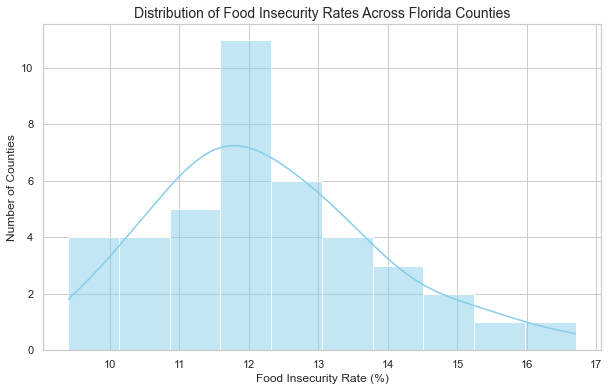

In [11]:
# Exploring the distribution of Food Insecurity Rate across Florida counties

# Set the plot style
sns.set(style="whitegrid")

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Food Insecurity Rate'], bins=10, kde=True, color='skyblue')

# Add labels and title
plt.title('Distribution of Food Insecurity Rates Across Florida Counties', fontsize=14)
plt.xlabel('Food Insecurity Rate (%)')
plt.ylabel('Number of Counties')

# Show the plot
plt.show()

### Wait pause... what does this mean?

Well, most counties fall within the 11% to 13.5% food insecurity range. 

Recall the df_clean.describe() function above. 

We know from the analysis that the food insecurity rate is:  

**Mean: 12.55%**  
**Standard Deviation: 1.45%**  
**Threshold: 14.00%**  

Given this information, we will create a benchmark that anything > 1 standard deviation above the mean is unusually high or high risk. We'll keep this in mind for later.


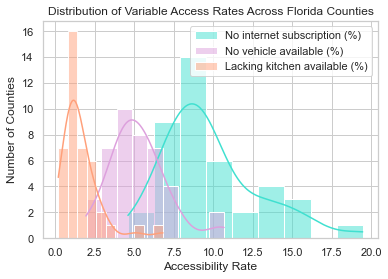

In [12]:
# Histogram analysis of food insecurities distribution across florida counties 

# Plotting overlapping histograms with KDE
sns.histplot(df_clean['No internet subscription (%)'], color='turquoise', alpha=0.5, kde=True, label='No internet subscription (%)')
sns.histplot(df_clean['No vehicle available (%)'], color='plum', alpha=0.5, kde=True, label='No vehicle available (%)')
sns.histplot(df_clean['Lacking kitchen available (%)'], color='lightsalmon', alpha=0.5, kde=True, label='Lacking kitchen available (%)')

# Adding labels and legend
plt.title('Distribution of Variable Access Rates Across Florida Counties')
plt.xlabel('Accessibility Rate')
plt.ylabel('Number of Counties')
plt.legend()

plt.show()


#### **Key Observations**
##### Distribution of Variable Access Rates Across Florida Counties Histogram 
The histogram provides a visual overview of Internet, Vehicle, and Kitchen accessibility across Florida counties.
The goal is to visually assess whether the variables shows patterns that suggest it could be a meaningful predictor of food insecurity.
- **No Internet Subscription**: The distribution is heavily skewed to the left, with the widest spread of data. This impacts a high number of counties, indicating that internet access is an issue in many counties. The data peaks around 7–10%, but stretches to 20% in some counties.
- **No Vehicle**: The distribution is slightly skewed to the left, with the data more varied. This could suggest that this variable might be statistically significant when predicting food insecurity. Around 2.5% to 7.5% of the population lack access to vehicle access.
- **No Kitchen**: The distribution is slightly skewed to the left, with around 0% to 2.5% of the population lacking kitchen access. This suggests that most counties have kitchens and may not impact food insecurity! Great news.


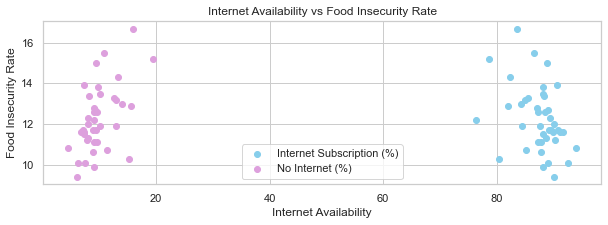

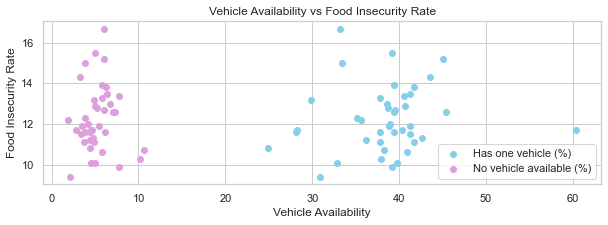

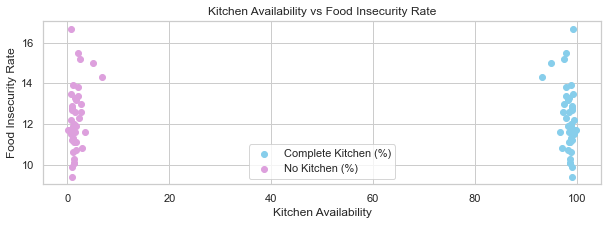

In [13]:
# Vehicle, Internet, and Kitchen access relation to Food Insecurity

# Scatter plot for Food Insecurity Rate vs Has one vehicle (%) and No vehicle available (%)
plt.figure(figsize=(10,3))
plt.scatter(df_clean['With internet subscription (%)'], df_clean['Food Insecurity Rate'], color='skyblue', label='Internet Subscription (%)')
plt.scatter(df_clean['No internet subscription (%)'], df_clean['Food Insecurity Rate'],  color='plum', label='No Internet (%)')
plt.xlabel('Internet Availability')
plt.ylabel('Food Insecurity Rate')
plt.title('Internet Availability vs Food Insecurity Rate')
plt.legend()

plt.figure(figsize=(10,3))
plt.scatter(df_clean['Has one vehicle (%)'], df_clean['Food Insecurity Rate'], color='skyblue', label='Has one vehicle (%)')
plt.scatter(df_clean['No vehicle available (%)'],df_clean['Food Insecurity Rate'], color='plum', label='No vehicle available (%)')
plt.xlabel('Vehicle Availability')
plt.ylabel('Food Insecurity Rate')
plt.title('Vehicle Availability vs Food Insecurity Rate')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.scatter(df_clean['Complete kitchen facility (%)'], df_clean['Food Insecurity Rate'], color='skyblue', label='Complete Kitchen (%)')
plt.scatter(df_clean['Lacking kitchen available (%)'], df_clean['Food Insecurity Rate'], color='plum', label='No Kitchen (%)')
plt.xlabel('Kitchen Availability')
plt.ylabel('Food Insecurity Rate')
plt.title('Kitchen Availability vs Food Insecurity Rate')
plt.legend()
plt.show()

plt.show()

#### **Key Observations:**
##### Scatter Plot and Regression Analysis  
The scatter plot provides a visual assessment of the relationship between the accessability of resources in FL counties to food insecurity.  
The goal is to visually assess whether the variables shows a correlation.

#### Internet Availability:
- **Observation**: More than 80% of people have internet access, while less than 20% do not. There is a large cluster between 11-14% for both subscription and non-subscription rates.
- **Correlation**: There is a very weak positive correlation between the lack of internet access and food insecurity rate. Higher food insecurity rates show a slight trend towards having a higher percentage of the population without internet access, but this trend is not strong.
- **What does this mean?**: While a large majority of the population has internet access regardless of food insecurity levels, communities with somewhat higher food insecurity rates may also have a slightly larger proportion of individuals without internet access. However, the lack of internet access doesn't appear to be a primary determinant of food insecurity based on this visualization.

#### Vehicle Availability:
- **Observation**: Data points for vehicle availability are more dispersed above 30%, while no vehicle availability has a tighter cluster below 10%. There is a focus of clusters between 11-12%, with dispersion increasing from 12-14% for both sets of data.
- **Correlation**: here is a weak positive correlation between the lack of vehicle access and food insecurity rate. Higher food insecurity rates show a slight tendency towards having a higher percentage of households with no vehicle available, but this relationship isn't very strong.
- **What does this mean?**: Higher food insecurity rates are associated with lower vehicle availability and higher percentages of populations without vehicle access.

#### Kitchen Availability:
- **Observation**: The data for kitchen availability is almost linear, indicating that most people have kitchen facilities. The relationship between kitchen availability and food insecurity rate appears proportional.
- **Correlation**: The correlation between the lack of kitchen facilities and food insecurity rate is weakly positive. While the percentage of households without a kitchen is very low overall, communities with slightly higher food insecurity rates might have a marginally higher (though still very small) percentage of households lacking complete kitchen facilities.
- **What does this mean?**: The presence of a complete kitchen is likely not a significant differentiator or strong predictor of food security in this dataset. While a lack of kitchen might be slightly more prevalent in food-insecure communities, its overall rarity suggests it's not a primary factor driving food insecurity rates.

In [14]:
# Regression Model: Correlation between variables and insecurity rate
import statsmodels.api as sm

X = df_clean[['Has one vehicle (%)', 'No vehicle available (%)', "Complete kitchen facility (%)", "Lacking kitchen available (%)", "With internet subscription (%)", "No internet subscription (%)"]]
y = df_clean['Food Insecurity Rate']

# Add a constant to the model
X = sm.add_constant(X)

# Fit the regression model
reg_model = sm.OLS(y, X).fit()

print(reg_model.summary())

                             OLS Regression Results                             
Dep. Variable:     Food Insecurity Rate   R-squared:                       0.391
Model:                              OLS   Adj. R-squared:                  0.304
Method:                   Least Squares   F-statistic:                     4.489
Date:                  Mon, 28 Apr 2025   Prob (F-statistic):            0.00290
Time:                          11:47:46   Log-Likelihood:                -67.141
No. Observations:                    41   AIC:                             146.3
Df Residuals:                        35   BIC:                             156.6
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

#### **Regression Analysis - Do these resources variable have any relationship with Food Insecurity?**

#### **Key Observations:**

The R-squared (0.391) indicate that ~39.1% of the variance in the "Food Insecurity Rate" can be explained by the independent variables included in our model. However it should be noted that the Adj. R-squared (0.304) delineates that not all of the variables might not be contributing significantly to the explanation of the variance.

Given that we have a low p-value .00290 (below alpha, 0.05), we can conclude that at least one of the independent variables in the model has a statistically significant relationship with the Food Insecurity Rate.

Looking further into the p-value for individual variables, we can answer the following questions.

- **No vehicle available (%):** p-value = 0.231 --> not statistically significant at the 0.05 level
- **Lacking kitchen available (%):** p-value = 0.156 --> not statistically significant at the 0.05 level
- **No internet subscription (%):** p-value = 0.005 --> statistically significant at the 0.05 level

Please note that we are dropping the 'Have Access' for each variable as we explored them simply to see the data in a wholistic view. 

#### Exploring Multicollinearity within variables

Now that we have explored the socioeconomic variables to the food insecurity rate, we will determine if there is any variance in our dataset by examining the relationship between the variables.

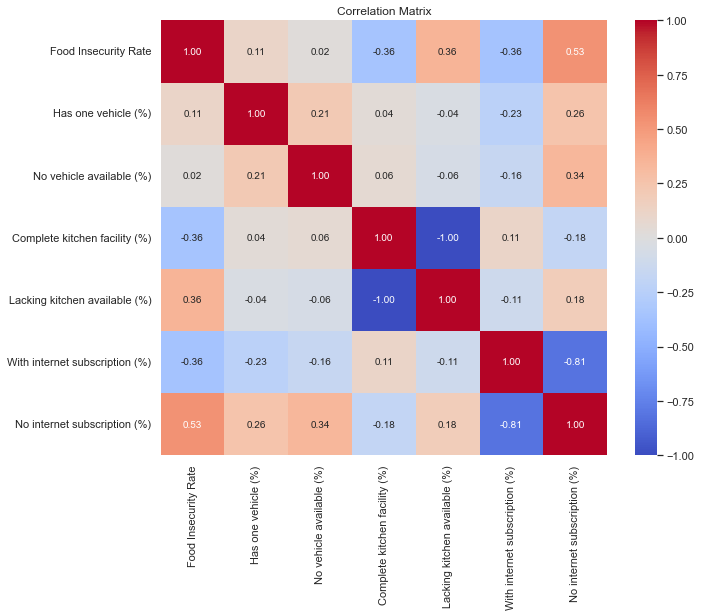

In [15]:
# Create a correlation matrix
corr_matrix = df_clean.drop(columns=['County']).corr()  # Drop County because it's text

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [16]:
# Exploring Multicollinearity with VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_clean[['No vehicle available (%)', 'Lacking kitchen available (%)', 'No internet subscription (%)']]

# Empty Dataframe
vif = pd.DataFrame()

vif["features"] = X.columns

vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,features,VIF Factor
0,No vehicle available (%),8.110729
1,Lacking kitchen available (%),2.725426
2,No internet subscription (%),9.848242


#### **Multicollinearity Analysis**

After running the VIF analysis, it can be determined that two of our three variables have high multicollinearity. High multicollinearity can distort the results of a regression model by making it hard to tell which variable is actually influencing the outcome.

No vehicle available (%) and No internet subscription (%) have high VIF values (> 5), indicating that they are strongly correlated. As the prediction model may struggle to decide which variable to "give credit" to when making predictions, we will be be dropping "No vehicle available (%)".

Lacking kitchen available (%) has a low VIF and can be used in the prediction model.

| Feature                      | VIF Value | Meaning                                   |
|:------------------------------|:----------|:------------------------------------------|
| No vehicle available (%)      | 8.11      | High multicollinearity (problematic)    |
| Lacking kitchen available (%) | 2.73      | No collinearity, independent factor                      |
| No internet subscription (%)  | 9.85      | Very high multicollinearity (critical) |



### **Phase 4: Prediction - Prediction model for high vs. low food insecurity**

The regression analysis revealed that the percentage of the population with no internet subscription has a statistically significant positive association with the Food Insecurity Rate. This suggests that communities with a higher proportion of individuals without internet access tend to experience higher levels of food insecurity. While this linear relationship delineates potential risk factors, for future applications such as resource allocation and targeted interventions, it might be useful to predict whether a community falls into a 'high' or 'low' food insecurity category. Therefore, the next step in our analysis is to develop classification models that can predict these distinct categories based on the same set of socioeconomic indicators.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm

# Create a Binary Classification for 'High' and 'Low' food insecurity
food_insecurity_mean = df_clean['Food Insecurity Rate'].mean()
food_insecurity_std = df_clean['Food Insecurity Rate'].std()

benchmark = food_insecurity_mean + food_insecurity_std


print(f"Mean Food Insecurity Rate: {round(food_insecurity_mean, 2)}%")
print(f"Standard Deviation: {round(food_insecurity_std, 2)}%")
print(f"Threshold for High Risk: {round(benchmark, 2)}%")

Mean Food Insecurity Rate: 12.26%
Standard Deviation: 1.61%
Threshold for High Risk: 13.87%


In [18]:
# Add binary classification into original dataset 
high_risk_counties = df_clean[df_clean['Food Insecurity Rate'] > benchmark]

df_clean['High Risk'] = (df_clean['Food Insecurity Rate'] > benchmark).astype(int)

df_risk = df_clean.iloc[:,[0,8,1,2,3,4,5,6,7]]

df_risk.head(5)
print(df_risk[['County','High Risk']]) # See which counties are classified as 'High Risk'

                 County  High Risk
0        Alachua County          0
1            Bay County          1
2        Brevard County          0
3        Broward County          0
4      Charlotte County          0
5         Citrus County          1
6           Clay County          0
7        Collier County          0
8       Columbia County          1
9          Duval County          0
10      Escambia County          0
11       Flagler County          0
12      Hernando County          1
13     Highlands County          1
14  Hillsborough County          0
15  Indian River County          0
16          Lake County          0
17           Lee County          0
18          Leon County          0
19       Manatee County          0
20        Marion County          0
21        Martin County          0
22    Miami-Dade County          0
23        Monroe County          0
24        Nassau County          0
25      Okaloosa County          0
26        Orange County          0
27       Osceola Cou

*Please note that only 41 out of 67 counties in FL are being evaluated. This is because of missing data from the 5 different datasets*

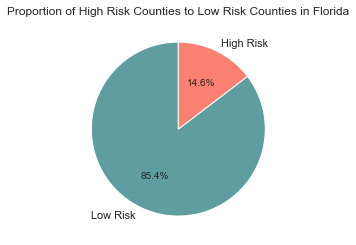

In [19]:
# Visualize the number of high risk to low risk counties
risk_counts = df_risk['High Risk'].value_counts()

# Generate a pie chart
fig, ax = plt.subplots()
ax.pie(risk_counts.values, labels=risk_counts.index.map({0: 'Low Risk', 1: 'High Risk'}), colors=['cadetblue', 'salmon'], autopct='%1.1f%%', startangle=90)

plt.title('Proportion of High Risk Counties to Low Risk Counties in Florida')
plt.show()

Please note that this pie chart indicates that we have a high imbalanced dataset. This will lead us to our next step, creating syntheic data for a more accurate prediction model. 

### **Prediction Model based off Regression model & VIF**

Based on the findings from the VIF analysis, we will build a prediction model for high-impact counties using the statistically significant factor of no internet accessibility.

It’s important to note that with only 47 counties in this dataset, it is too small to build a reliable and accurate prediction model. As such, we will be synthesizing additional data to expand the dataset and then run a prediction model on the larger dataset.

#### **Using Bootstrapping for Model Validation**
- Given that we only have 47 counties in our dataset, bootstrapping will stabalize our model and provide a reliabile prediction of High/Low risk counties
- Provides an estimate of model variability, allowing measurment of uncertainty in predictions and a better understanding of the model's generalization ability

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from collections import Counter

In [33]:
# Step 1: Set up features and target
X = df_risk[['No internet subscription (%)']]  # Your chosen feature(s)
y = df_risk['High Risk']  # Target variable

# Step 2: Split the data into training and test sets (increase test size to 30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

# Count your training labels
counter = Counter(y_train)

# How many samples do you have for the minority class?
minority_class_count = min(counter.values())

# Set k_neighbors safely (can't be >= number of minority samples)
safe_k_neighbors = min(5, minority_class_count - 1)

# Initialize SMOTE with a safe number of neighbors
smt = SMOTE(k_neighbors=safe_k_neighbors, random_state=100)

# Apply SMOTE to the training data
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

# Check new class balance
print('After resampling:', Counter(y_train_sm))

After resampling: Counter({1: 20, 0: 20})


There is an equal distribution of low-risk (class 0) and high-risk (class 1) samples.
<br>
The imbalance issue is resolved.

#### **Prediction Model: No internet subscription (%) & Food Insecurity Rate**

In [34]:
# Step 3: Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=100)

# Step 4: Train (fit) the model on the SMOTE-resampled training data
log_reg.fit(X_train_sm, y_train_sm)

# Step 5: Predict on the test set (X_test is *NOT* SMOTE-resampled)
y_pred = log_reg.predict(X_test)

# Step 6: Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[14  1]
 [ 1  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.50      0.50      0.50         2

    accuracy                           0.88        17
   macro avg       0.72      0.72      0.72        17
weighted avg       0.88      0.88      0.88        17


Accuracy Score:
0.8823529411764706


### **Analysis:**

With an accuracy of 88.2%, the model is showing decent performance but still has room for improvement, especially in its ability to correctly predict high-risk communities.

Given that 17 samples were tested in the test set, 15 were found to be low risk and 2 to be high risk.

#### **Key Observations:**

##### Low Risk: correctly identified most low-risk communities and is reliable
- The model correctly identified 93% of all predictions for low-risk communities.
- TThe model captured 93% of all actual low-risk communities.
- The model balances precision and recall well for low-risk communities.
  
##### High Risk: weak prediction, missing many high-risk communities (both false negatives and false positives)
- The model only correctly identified 50% of high-risk communities.
- The model identified 50% of all actual high-risk communities.
- The model struggles to balance precision and recall for high-risk communities.

##### Looking at the confustion matrix:
- True Negatives (TN): **14 samples correctly predicted as low risk (class 0)**

- False Positives (FP): **1 sample incorrectly predicted as high risk when it was actually low risk**

- False Negatives (FN): **1 sample incorrectly predicted as low risk when it was actually high risk**

- True Positives (TP): **1 sample correctly predicted as high risk (class 1)**



#### Limitation

The model may still be influenced by data imbalance, especially considering the performance drop for the minority class (high risk). Even after applying SMOTE, the small sample size (only 2 high-risk samples) can lead to overfitting or underperformance for that class.


<br> 



### **Exploring prediction model for all 3 variables**

The data's imbalance is causing our model to have poor performance for the high-risk minority class. Despite applying SMOTE, due to the extremely small sample size, the prediction model cannot be used. A larger sample of high-risk communities is needed to improve the model's precision and recall for this critical class and prevent overfitting.
<br>
We will explore all three variables which will provide a more comprehensive understanding of food insecurity factors, as well as draw the relation betwen complex interactions between variables. The model will likely generalize well despite the current dataset limitations.

In [ ]:
#Split and train data to make predictions

# Asign X and y labels
X = df_risk[['No vehicle available (%)', "Lacking kitchen available (%)", "No internet subscription (%)"]]
y = df_risk['High Risk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of the Logistic Regression model: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy of the Logistic Regression model: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.67      0.80         3

    accuracy                           0.92        13
   macro avg       0.95      0.83      0.88        13
weighted avg       0.93      0.92      0.92        13

Confusion Matrix:
[[10  0]
 [ 1  2]]


### **Analysis:**

With an accuracy of 92%, we can state that the model is performing well but still making a few errors. 

Given that 13 samples were tested in the test set, 10 were found to be low risk and 3 to be high risk.

#### **Key Observations**
##### Low Risk 
- When the model predicted a community as low risk (class 0), it was correct 91% of the time.
- The model correctly identified 100% of the actual low-risk communities in the test set.
- The F1-score is high, indicating a good balance between precision and recall for the low-risk class.

  
##### High Risk
- The model predicted a community as high risk with 100% accuracy. There were no false positives.
- The model correctly identified 67% of the high-risk communities in the test set (missing 1 out of 3).
- The F1-score (at .80) is still good but lower than the low-risk class. This could potenally mean there's an imbalance in performance. This could be due to the smaller number of high-risk samples in the test set

##### Looking at the confustion matrix:
- True Negatives (TN): The model correctly predicted **10 low-risk communities**.
- False Positives (FP): The model incorrectly predicted **0 low-risk communities as high risk**.
- False Negatives (FN): The model incorrectly predicted **1 high-risk community as low risk**.
- True Positives (TP): The model correctly predicted **2 high-risk communities**.


## Conclusion
### What does this study mean?

The regression analysis, by identifying "No internet subscription (%)" as a statistically significant factor positively associated with the continuous "Food Insecurity Rate," lays the groundwork for practical application by highlighting a key vulnerability. Subsequently, the successful classification model, which likely incorporates this relationship along with other socioeconomic indicators, demonstrates the predictive utility of these factors in categorizing communities as high or low risk. This consistency between identifying a significant association and achieving accurate risk prediction allows for targeted interventions, policy recommendations, resource allocation, and further research into the underlying causes of food insecurity, ultimately enabling data-driven strategies to support vulnerable populations better. 

With a starting point/emphasis on internet subscriptions, resources can be allocated there. We can consider the other vehicles and perhaps advocate for more readily available public transport. Though our dataset was small, we can apply it to bigger datasets like all counties in the US.

### Future Works
- If possible, more data should be gathered for the high-risk class. Having more samples of high-risk communities would allow SMOTE to generate more diverse synthetic examples, which can help the model perform better. Perhaps the addition of data from more than 1 year, or 1 state could give us a better prediction model. 
- While the regression analysis identified statistically significant associations and the classification model demonstrated predictive power, correlation does not imply causation. The socioeconomic indicators you used might be correlated with other underlying factors that directly influence food insecurity. Further research using causal inference techniques would be needed to establish causal relationships.
-  Your choice of one standard deviation above the mean to define "high risk" is a statistical convention. This threshold might not align with real-world definitions used by practitioners or policymakers. The model's performance could vary depending on the chosen threshold, and a different threshold might be more appropriate for specific applications.
-   While Logistic Regression offers some interpretability, more complex models might achieve higher predictive accuracy but be harder to understand and explain.
<br>
<br>
<br>
<br>
<br>

## Summary

This project investigated the relationship between access to basic resources (internet, vehicle, kitchen) and food insecurity rates across counties in Florida.


#### **Our goals were to:**

• Explore the socioeconomic factors influencing food insecurity.

• Classify counties into high-risk and low-risk groups based on food insecurity rates.

• Build a predictive model to estimate food insecurity risk based on accessibility factors. 
  
<br>

#### **Key Steps:**

**1. Data Collection and Cleaning:**

• Collected 2019–2022 socioeconomic data from the American Community Survey (ACS).

• Normalized access variables (internet, vehicle, kitchen) by county population.
<br>

**2. Data Exploration:**

• Created scatterplots and histograms to visualize relationships between access variables and food insecurity rates.

• Identified lack of internet access as a particularly strong correlate of food insecurity.
<br>

**3. Statistical Analysis:**

• Conducted a correlation analysis and a Variance Inflation Factor (VIF) test.

• Found that internet access and vehicle access are highly correlated (high VIF values), suggesting multicollinearity.
<br>

**4. Decision-Making:**

• Based on multicollinearity results, we decided to prioritize lack of internet access as the main feature for prediction.

• Vehicle access was considered but treated carefully due to potential redundancy.
<br>

**5. Prediction Preparation:**

• Set a threshold for high/low food insecurity based on the mean plus standard deviation of the food insecurity rates.

• Classified counties accordingly to prepare labels for machine learning.

<br>

#### **Main Findings:**

• Internet access is a strong and statistically significant predictor of food insecurity risk.

• Vehicle access shows some relationship but overlaps heavily with internet access, so using only internet access improves model simplicity and reliability.

<br>

#### **Impact:**

• The insights suggest that improving internet infrastructure may help mitigate food insecurity risks.

• The prediction model can help target interventions more effectively by identifying high-risk counties using simple, available socioeconomic data.